In [1]:
import os
os.environ['KERAS_BACKEND'] = 'torch'

import zipfile
import random
import shutil
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

print(f"Keras version: {keras.__version__}")
print(f"Using backend: {keras.backend.backend()}")

Keras version: 3.10.0
Using backend: torch


Step 1: Load the MRI Image Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Paths to folders
train_dir = '/content/drive/MyDrive/Colab Notebooks/Training'
test_dir = '/content/drive/MyDrive/Colab Notebooks/Testing'

classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
target_size = (224, 224)  # resize all images to 224x224

def load_images_from_folder(folder_path, classes, target_size):
    images = []
    labels = []
    for idx, class_name in enumerate(classes):
        class_folder = os.path.join(folder_path, class_name)
        for filename in os.listdir(class_folder):
            img_path = os.path.join(class_folder, filename)
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize(target_size)
                images.append(np.array(img))
                labels.append(idx)
            except Exception as e:
                print(f"Failed to load {img_path}: {e}")
    return np.array(images), np.array(labels)

# Load training images
X_train, y_train = load_images_from_folder(train_dir, classes, target_size)

# Load testing images
X_test, y_test = load_images_from_folder(test_dir, classes, target_size)

print(f"Train images: {X_train.shape}, Train labels: {y_train.shape}")
print(f"Test images: {X_test.shape}, Test labels: {y_test.shape}")

Train images: (5712, 224, 224, 3), Train labels: (5712,)
Test images: (1311, 224, 224, 3), Test labels: (1311,)


Step 2: Convert the data to tumor and notumor

In [4]:
# Collapse labels: tumor = 0, notumor = 1
y_train_binary = np.where(y_train == classes.index("notumor"), 1, 0)
y_test_binary = np.where(y_test == classes.index("notumor"), 1, 0)

print(np.unique(y_train_binary, return_counts=True))
print(np.unique(y_test_binary, return_counts=True))

(array([0, 1]), array([4117, 1595]))
(array([0, 1]), array([906, 405]))


Step 3: Split Dataset into Training, Validation, and Test Sets

In [5]:
from sklearn.model_selection import train_test_split

# Split training images into train and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train,
    y_train_binary,
    test_size=0.1,       # 10% validation
    random_state=42,     # reproducibility
    stratify=y_train_binary     # keeps class balance
)

Step 4: Create Data Generators with Augmentation

In [6]:
def train_val_generators(X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Creates the training, validation, and test data generators
    for manually loaded NumPy arrays.

    Args:
      X_train, y_train: training images and labels
      X_val, y_val: validation images and labels
      X_test, y_test: testing images and labels

    Returns:
      train_generator, validation_generator, test_generator
    """

    # Training generator with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Validation/test generator (no augmentation)
    val_test_datagen = ImageDataGenerator(rescale=1./255)

    # Use .flow() for NUMPY arrays
    train_generator = train_datagen.flow(
        X_train, y_train,
        batch_size=32,
        shuffle=True
    )

    validation_generator = val_test_datagen.flow(
        X_val, y_val,
        batch_size=32,
        shuffle=False
    )

    test_generator = val_test_datagen.flow(
        X_test, y_test,
        batch_size=32,
        shuffle=False
    )

    return train_generator, validation_generator, test_generator

In [7]:
# Test your generators
train_generator, validation_generator, test_generator = train_val_generators(X_train_split, y_train_split, X_val, y_val, X_test, y_test_binary)

CNN Architecture

In [8]:
from tensorflow import keras
from tensorflow.keras.metrics import Recall

def create_model():

    model = keras.models.Sequential([
        keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224,224,3)),
        keras.layers.MaxPooling2D((2,2)),

        keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2,2)),

        keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2,2)),

        keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2,2)),

        keras.layers.Flatten(),
        keras.layers.Dense(512, activation='relu'),

        # final binary output layer
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', Recall()]
    )

    return model


In [9]:
# create the untrained model
model = create_model()

# Display model architecture
model.summary()

# Count parameters
total_params = model.count_params()
print(f"Total parameters in the model: {total_params}")

# Train the model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,086,913 (49.92 MB)

 Trainable params: 13,086,913 (49.92 MB)

 Non-trainable params: 0 (0.00 B)

Total parameters in the model: 13086913


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 76s 457ms/step - accuracy: 0.7952 - loss: 0.4859 - recall: 0.3973 - val_accuracy: 0.9318 - val_loss: 0.2296 - val_recall: 0.9625
Epoch 2/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 70s 431ms/step - accuracy: 0.9367 - loss: 0.1916 - recall: 0.8566 - val_accuracy: 0.9580 - val_loss: 0.1172 - val_recall: 0.9187
Epoch 3/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 95s 591ms/step - accuracy: 0.9487 - loss: 0.1610 - recall: 0.9024 - val_accuracy: 0.9703 - val_loss: 0.0826 - val_recall: 0.9438
Epoch 4/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 70s 433ms/step - accuracy: 0.9429 - loss: 0.1651 - recall: 0.8996 - val_accuracy: 0.9668 - val_loss: 0.0919 - val_recall: 0.9812
Epoch 5/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 70s 436ms/step - accuracy: 0.9562 - loss: 0.1365 - recall: 0.9273 - val_accuracy: 0.9703 - val_loss: 0.0773 - val_recall: 0.9937
Epoch 6/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 71s 438ms/step - accuracy: 0.9555 - loss: 0.1212 - recall: 0.9375 - val_accuracy: 0.9598 - val_loss: 0.0966 - val_r

Visualize Training Progress

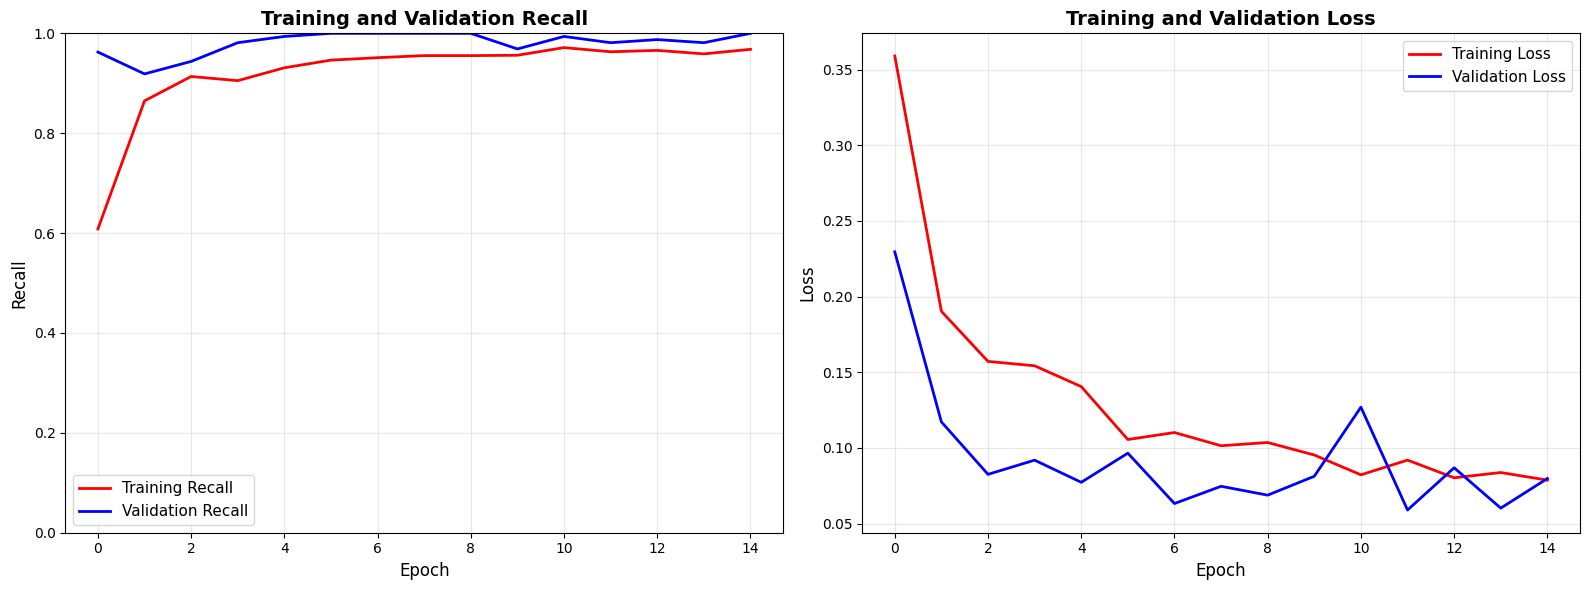


  Training Summary (Recall + Loss)
  Best Training Recall:     0.9714 (epoch 11)
  Best Validation Recall:   1.0000 (epoch 6)
  Final Training Recall:    0.9679
  Final Validation Recall:  1.0000
  Recall Gap (final):       0.0321
------------------------------------------------------------


In [10]:
# Extract training history
recall = history.history['recall']
val_recall = history.history['val_recall']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(recall))

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Recall
ax1.plot(epochs_range, recall, 'r-', linewidth=2, label="Training Recall")
ax1.plot(epochs_range, val_recall, 'b-', linewidth=2, label="Validation Recall")
ax1.set_title('Training and Validation Recall', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Recall', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1])

# Plot 2: Loss
ax2.plot(epochs_range, loss, 'r-', linewidth=2, label="Training Loss")
ax2.plot(epochs_range, val_loss, 'b-', linewidth=2, label="Validation Loss")
ax2.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n{'='*60}")
print(f"  Training Summary (Recall + Loss)")
print(f"{'='*60}")
print(f"  Best Training Recall:     {max(recall):.4f} (epoch {recall.index(max(recall))+1})")
print(f"  Best Validation Recall:   {max(val_recall):.4f} (epoch {val_recall.index(max(val_recall))+1})")
print(f"  Final Training Recall:    {recall[-1]:.4f}")
print(f"  Final Validation Recall:  {val_recall[-1]:.4f}")
print(f"  Recall Gap (final):       {abs(recall[-1] - val_recall[-1]):.4f}")
print(f"{'-'*60}")


Test Statistics

In [11]:
test_loss, test_acc, test_recall = model.evaluate(test_generator)

print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Recall:   {test_recall:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9017 - loss: 0.1818 - recall: 0.5671
Test Loss:     0.1685
Test Accuracy: 0.9130
Test Recall:   0.9951


Confusion Matrix

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
[[794 112]
 [  2 403]]


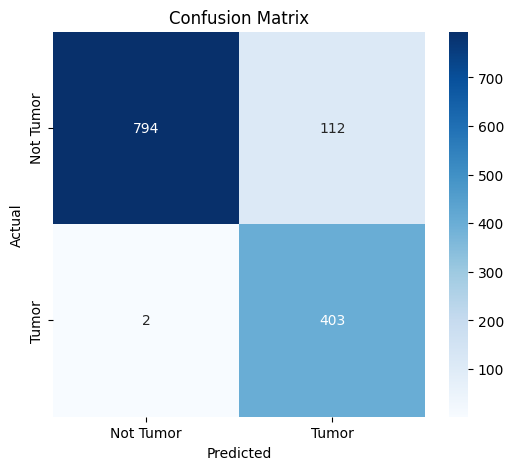

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int).ravel()
y_true = y_test_binary

cm = confusion_matrix(y_true, y_pred)
print(cm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Tumor', 'Tumor'],
            yticklabels=['Not Tumor', 'Tumor'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()